# Projet LOCALIZATION

##### Chargement des modules nécéssaires

In [83]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt # plots
import os 
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Conv1D, Masking, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

##### Chargement des données

In [61]:
file_data_train = "reduced_train.npz"

data = np.load(file_data_train)
X = data["X_train"]
Y = data["y_train"]
mask = data["mask_train"]

import random as rd

#Taille de l'échantillon
n = len(X)

#Définition des data train et test
index_train = np.random.choice([i for i in range(0,n)], size=int(n * 0.7), replace=False)  # replace=False signifie sans remise

#Données train
X_train = X[index_train]
Y_train = Y[index_train]
mask_train = mask[index_train]

#Données test
index_test = np.setdiff1d(np.arange(n), index_train)
X_test = X[index_test]
Y_test = Y[index_test]
mask_test = mask[index_test]

In [62]:
print(X_train.shape)
print(X_test.shape)

(1696, 400, 20)
(727, 400, 20)


Il y a 2423 séquences au total qui contienent chacune 400 position. Pour chaque position il y a 20 probabilités pour chaque acide aminé. Chaque séquence est alors représentée sous la forme d'une matrice de poids.

In [63]:
print(Y.shape)

(2423,)


In [64]:
print(np.unique(Y))

[0 1 2 3 4 5 6 7 8 9]


Chaque séquence est associée à un des 10 labels

In [65]:
mask.shape

(2423, 400)

In [67]:
np.unique(mask[0])

array([0., 1.], dtype=float32)

Étant donné que nous travaillons avec des séquences protéiques, le masque nous permet d’identifier les positions considérées comme "valides". Nous allons réaliser un apprentissage à la fois sur les données brutes et sur les données filtrées par le masque. Il serait intéressant d’examiner s'il existe une différence de performance en tenant compte de la validité de chaque position.

##### One Hot Encoding des labels (OHE)

In [88]:
y_train_oh = pd.get_dummies(Y_train) # OHE
y_test_oh = pd.get_dummies(Y_test) # OHE
y_train_oh.shape

(1696, 10)

### CNN avec bottleneck (données brutes)

Je fais l'usage du bottleneck pour réduire la dimension de mes données et d'optenir un apprentissage plus rapide (via réduction des cannaux intermédiaires). L'avantage du bottleneck dans un CNN c'est qu'on va réduire le surapprentissage. 

Dans la cellule suivante on va définir un block bottleneck. C'est la structure qui sera utilisée dans le CNN.

In [167]:
def bottleneck_block(input_tensor, filters):
    # Convolution 1x1 (réduction de dimension)
    x = Conv1D(filters, kernel_size=1, strides=1, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Convolution 3x3 (transformation)
    x = Conv1D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Convolution 1x1 (restauration de la dimension de l'input)
    x = Conv1D(input_tensor.shape[-1], kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Skip connection 
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    
    return x

In [171]:
input_tensor = Input(shape=(400, 20))
output_tensor = bottleneck_block(input_tensor, filters=10)

# Global Average Pooling pour réduire à un vecteur de 10
x = GlobalAveragePooling1D()(output_tensor)

# Couche Dense pour prédire les 10 classes
output_tensor = Dense(10, activation='softmax')(x)  # Sortie pour 10 classes

model = Model(inputs=input_tensor, outputs=output_tensor)

#Compilation du modèle
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #Classification multiclasse
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 400, 10)   │        210 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 10)   │         40 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 400, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 400, 10)   │        310 │ activation_56[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 10)   │         40 │ conv1d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 400, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 400, 20)   │        220 │ activation_57[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│                     │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 400, 20)   │          0 │ add_18[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 20)        │          0 │ activation_58[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        210 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,110 (4.34 KB)

 Trainable params: 1,030 (4.02 KB)

 Non-trainable params: 80 (320.00 B)

In [172]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [173]:
#Entrainement du modèle
history = model.fit(X_train, y_train_oh, epochs=100, validation_data=(X_test, y_test_oh), batch_size=50,callbacks=[early_stopping])

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - categorical_accuracy: 0.0413 - loss: 2.3970 - val_categorical_accuracy: 0.0977 - val_loss: 2.2598
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.2207 - loss: 2.1522 - val_categorical_accuracy: 0.2146 - val_loss: 2.2091
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3353 - loss: 2.0391 - val_categorical_accuracy: 0.2902 - val_loss: 2.1548
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.3175 - loss: 1.9775 - val_categorical_accuracy: 0.2916 - val_loss: 2.1020
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.3410 - loss: 1.9186 - val_categorical_accuracy: 0.3012 - val_loss: 2.0538
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3516 - loss: 1.8717 - val_categorical_accuracy: 0.3122 - val_loss: 2.0115
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3742 - loss:

##### Critique des performances du modèle

In [174]:
# Afficher l'accuracy à la dernière époque d'entraînement
train_accuracy = history.history['categorical_accuracy'][-1]
print(f"Accuracy sur l'entraînement à la dernière époque: {train_accuracy}")

#  afficher l'accuracy sur la validation
val_accuracy = history.history['val_categorical_accuracy'][-1]
print(f"Accuracy sur la validation à la dernière époque: {val_accuracy}")

Accuracy sur l'entraînement à la dernière époque: 0.6886792182922363
Accuracy sur la validation à la dernière époque: 0.6547455191612244


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


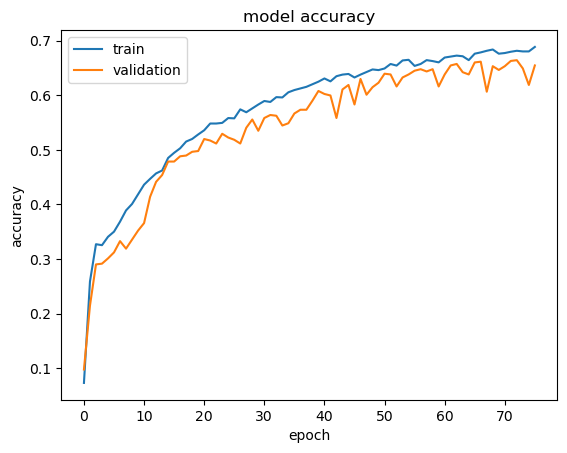

In [175]:
print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

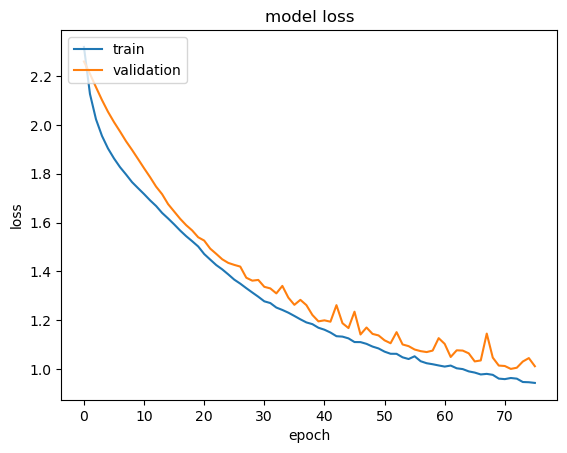

In [176]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [177]:
pred_raw = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Grâce au bottleneck, le modèle à été plus rapide lors de l'apprentissage qu'un CNN classique. De plus, on apercoit qu'entre l'apprentissage et la validation, la fonction de perte à été très bien minimisée et le gradient à convergé. Les performances sont plutôt bonnes (65% de bonnes réponses en validation).

Maintenant, utiilisons le masque pour apprendre les données et regarder si on a une meilleure performance.

### CNN avec bottleneck (données avec mask)

Dans un premier temps on va remplacer les données masquées par 0 dans X_train.

In [178]:
from tensorflow.keras.layers import Masking
X_train_masked = np.copy(X_train)
X_train_masked[mask_train == 0] = 0

X_test_masked = np.copy(X_test)
X_test_masked[mask_test== 0] = 0

Ensuite on va modifier l'input tensor de notre modèle en précisant que les données égales à 0 doivent être ignorées.

In [179]:
input_tensor = Input(shape=(400, 20))
masked_input = Masking(mask_value=0.0)(input_tensor)
output_tensor = bottleneck_block(masked_input, filters=10)

# Réduire avec une GlobalAveragePooling1D
x = GlobalAveragePooling1D()(output_tensor)

#Couche dense pour la classification (10 classes)
output_tensor = Dense(10, activation='softmax')(x)

C:\Users\Rose Tchala Sare\anaconda3\Lib\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'conv1d_62' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [180]:
model_masked = Model(inputs=masked_input, outputs=output_tensor)

#Compilation du modèle
model_masked.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #Classification multiclasse
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

model_masked.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_266CL… │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 400, 10)   │        210 │ keras_tensor_266… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 10)   │         40 │ conv1d_62[1][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 400, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 400, 10)   │        310 │ activation_59[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 10)   │         40 │ conv1d_63[1][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 400, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 400, 20)   │        220 │ activation_60[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_64[1][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│                     │                   │            │ keras_tensor_266… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_61       │ (None, 400, 20)   │          0 │ add_19[1][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 20)        │          0 │ activation_61[1]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10)        │        210 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,110 (4.34 KB)

 Trainable params: 1,030 (4.02 KB)

 Non-trainable params: 80 (320.00 B)

In [181]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model_masked.fit(X_train_masked, y_train_oh, epochs=200, validation_data=(X_test_masked, y_test_oh), batch_size=50,callbacks=[early_stopping])

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.1701 - loss: 2.3097 - val_categorical_accuracy: 0.2682 - val_loss: 2.2164
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.2205 - loss: 2.1350 - val_categorical_accuracy: 0.2682 - val_loss: 2.1495
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.2544 - loss: 2.0222 - val_categorical_accuracy: 0.2682 - val_loss: 2.0989
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.3335 - loss: 1.9346 - val_categorical_accuracy: 0.2503 - val_loss: 2.0645
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3850 - loss: 1.8794 - val_categorical_accuracy: 0.1609 - val_loss: 2.0510
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.4264 - loss: 1.8403 - val_categorical_accuracy: 0.1554 - val_loss: 2.0333
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.4436 - loss:

##### Critique des performances du modèle

In [182]:
# Afficher l'accuracy à la dernière époque d'entraînement
train_accuracy = history.history['categorical_accuracy'][-1]
print(f"Accuracy sur l'entraînement à la dernière époque: {train_accuracy}")

#  afficher l'accuracy sur la validation
val_accuracy = history.history['val_categorical_accuracy'][-1]
print(f"Accuracy sur la validation à la dernière époque: {val_accuracy}")

Accuracy sur l'entraînement à la dernière époque: 0.7600235939025879
Accuracy sur la validation à la dernière époque: 0.7138926982879639


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


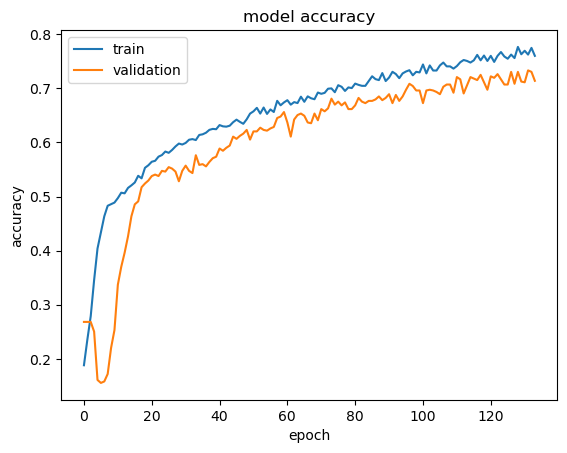

In [183]:
print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

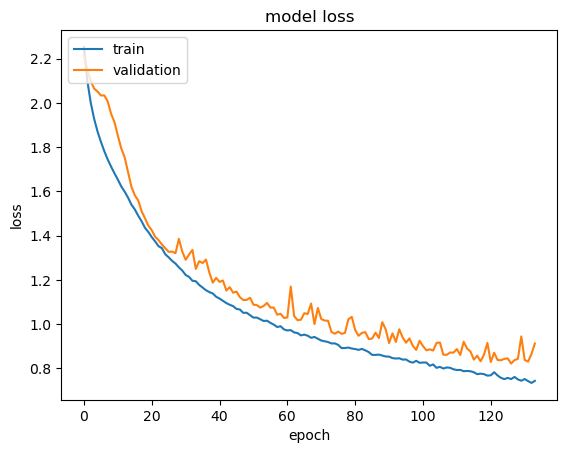

In [184]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

On voit que les performances sont légèrement meilleures qu'avec les données non masquées. En validation, la minimisation de la fonction loss à un peu u mal à converger et il a fallu plus d'épochs. J'aimerais bien voir si il y a une différence statistique dans la prédiction des classes entre les deux modèles.

In [185]:
pred_masked = model_masked.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### Comparaison des performances des deux modèles

In [186]:
#Les vecteurs pred CNN et pred Dense contiennent des probabilités. On doit récuperer pour chaque élement la classe la plus probable.
classes_MASKED = np.argmax(pred_masked, axis=1)
classes_RAW = np.argmax(pred_raw, axis=1)

#On crée un vecteur avec les occurences de chaque classe
occ_MASKED = np.unique(classes_MASKED, return_counts=True)
occ_RAW = np.unique(classes_RAW, return_counts=True)

In [187]:
print(occ_MASKED)
print(occ_RAW)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([112, 256, 150,  50,  79,   1,  59,  17,   3], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([ 97, 264, 163,  28,  77,   1,  77,  16,   4], dtype=int64))


<BarContainer object of 9 artists>

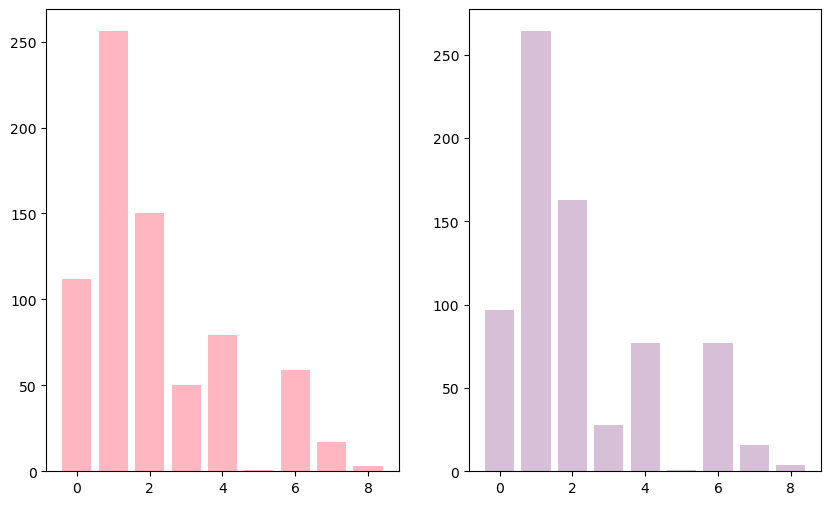

In [188]:
#On va visualiser les occurences dans un barplot

num_rows, num_cols = 1, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

#vecteur contenant le label de chaque classe
classe =occ_MASKED[0]

ax = axes.flat[0]
ax.bar(occ_MASKED[0], occ_MASKED[1], color='lightpink')

ax = axes.flat[1]
ax.bar(occ_RAW[0], occ_RAW[1], color='thistle')


On voit qu'il y a pas vraiment de grandes différence dans la distribution de la prédiction des classes avec l'apprentissage sur des données masquées (rose). On va faire un test du Chi-deux pour voir si il existe une différence statistique dans la distribution des classes.

In [190]:
from scipy.stats import chi2_contingency

data = np.array([occ_MASKED[1], occ_RAW[1]]).T

# Effectuer le test du chi-deux
chi2_stat, p_value, dof, expected = chi2_contingency(data)

# Afficher les résultats
print(f"Statistique du chi-deux: {chi2_stat}")
print(f"Valeur p: {p_value}")
print(f"Degrés de liberté: {dof}")

Statistique du chi-deux: 10.525850394342664
Valeur p: 0.23003851186867946
Degrés de liberté: 8


La p-value est supérieure à 0.05. Il n'y a pas de différence statistique entre la distruction des classes pour les données test entre les deux modèles. Donc je peux dire que faire l'entrainement sur des données masquées ou non masquées n'a pas vraiment amélioré la performance du modèle.

Toutefois je tiens à dire que l'apprentissage est rapide en utilisant bottleneck. Cela nous permet de lancer plus d'épochs. Une autre alternative aurait été d'utiliser un modèle transformers et regarder si il y a une différence de performance avec le CNN.